<a href="https://colab.research.google.com/github/Safat99/emergency_vehicle_detection/blob/main/vgg_16_approach/emergency_car_classification_with_vgg16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
pwd

'/content'

In [ ]:
%cd drive/MyDrive/vgg_16_approach/

/content/drive/MyDrive/vgg_16_approach


In [ ]:
import os
os.getcwd()

'/content/drive/MyDrive/vgg_16_approach'

In [ ]:
mkdir outputs

mkdir: cannot create directory ‘outputs’: File exists


In [ ]:
#!python3 train.py

In [ ]:
from sklearn.utils import shuffle
import config
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LayerNormalization
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from imutils import paths
import numpy as np
import os
import pandas as pd
import pickle


In [ ]:
print("[INFO} loading dataset...")


data = [] #images
labels = []
bboxes = []
filenames = []
imagePaths = []


[INFO} loading dataset...


In [ ]:
config.NUM_EPOCHS = 25

In [ ]:
cars = pd.read_csv(os.path.join(config.base_path,'images', 'train_test_vgg_format.csv'))

In [ ]:
for i in cars.IMAGE:
	image = load_img(os.path.join(config.images_path, str(i) + ".jpg"))
	image = img_to_array(image)
	
	data.append(image)
	imagePaths.append(os.path.join(config.images_path, str(i) + ".jpg"))

tmp = []

for i in range(len(cars)):
	for j in range(1,5):
		tmp.append(cars.iloc[i,j])

	labels.append(cars.CLASS[i])
	bboxes.append(tmp)
	tmp = []



In [ ]:
# convert the data and labels to NumPy arrays, scaling the input
# pixel intensities from the range [0, 255] to [0, 1]
data = np.array(data, dtype="float32") / 255.0
labels = np.array(labels)
bboxes = np.array(bboxes, dtype='float32')
imagePaths = np.array(imagePaths)

lb = LabelBinarizer()
labels = lb.fit_transform(labels)

if len(lb.classes_) == 2:
	labels = to_categorical(labels)

In [ ]:
# partition the data into training and testing splits using 90% of
# the data for training and the remaining 10% for testing
train_images,test_images,trainLabels,testLabels,trainBboxes, testBboxes, trainPaths, testPaths = train_test_split(data, labels, bboxes, imagePaths, test_size=0.20,
	random_state=42, shuffle = True)

# write the testing filenames to disk so that we can use then
# when evaluating/testing our bounding box regressor
print("[INFO] saving testing filenames...")
f = open(config.test_path, "w")
f.write("\n".join('testPaths'))
f.close()

[INFO] saving testing filenames...


#############################			DL starts			###########################################
##########start the model>>> this may have to be changed if not satisfactory result ###############

In [ ]:
vgg = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# freeze all VGG layers so they will *not* be updated during the
# training process
vgg.trainable = False

# flatten the max-pooling output of VGG
flatten = vgg.output
flatten = Flatten()(flatten)

# construct a fully-connected layer header to output the predicted
# bounding box coordinates
bboxHead = Dense(128, activation="relu")(flatten)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid",
	name="bounding_box")(bboxHead)
#bboxHead.add(BatchNormalization()) 

# construct a second fully-connected layer head, this one to predict
# the class label
#softmaxHead = LayerNormalization()
softmaxHead = Dense(512, activation="relu")(flatten)
#layer = BatchNormalization()
#softmaxHead = layer(softmaxHead)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(512, activation="relu")(softmaxHead)
softmaxHead = Dropout(0.5)(softmaxHead)
#layer_2 = BatchNormalization()
#layer_2 = LayerNormalization()
#softmaxHead = layer_2(softmaxHead)
#softmaxHead = BatchNormalization()
softmaxHead = Dense(len(lb.classes_), activation="softmax", 
                    name="class_label")(softmaxHead)
# put together our model which accept an input image and then output
# bounding box coordinates and a class label

In [ ]:
model = Model(
	inputs=vgg.input,
	outputs=(bboxHead, softmaxHead))


In [ ]:
# define a dictionary to set the loss methods -- categorical
# cross-entropy for the class label head and mean absolute error
# for the bounding box head
losses = {
	"class_label": "categorical_crossentropy",
	"bounding_box": "mean_squared_error",
}
# define a dictionary that specifies the weights per loss (both the
# class label and bounding box outputs will receive equal weight)
lossWeights = {
	"class_label": 1.0,
	"bounding_box": 1.0
}
# initialize the optimizer, compile the model, and show the model
# summary
opt = Adam(learning_rate=config.INIT_LR)
model.compile(loss=losses, optimizer=opt, metrics=["accuracy"], loss_weights=lossWeights)
print(model.summary())

# construct a dictionary for our target training outputs
trainTargets = {
	"class_label": trainLabels,
	"bounding_box": trainBboxes
}
# construct a second dictionary, this one for our target testing
# outputs
testTargets = {
	"class_label": testLabels,
	"bounding_box": testBboxes
}


Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_16[0][0]                   
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
____________________________________________________________________________________________

In [ ]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_16[0][0]                   
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
____________________________________________________________________________________________

In [ ]:
config.NUM_EPOCHS

25

In [ ]:
import IPython
display(IPython.display.Audio(url="https://ssl.gstatic.com/dictionary/static/sounds/20180430/complete--_us_1.mp3", autoplay=True))

In [ ]:
print("[INFO] training model...")
H = model.fit(
	train_images, trainTargets,
	validation_data=(test_images, testTargets),
	batch_size=config.BATCH_SIZE,
	epochs=config.NUM_EPOCHS,
	verbose=1)
# serialize the model to disk
print("[INFO] saving object detector model...")
model.save(config.model_path, save_format="h5")

### latelty added for the training history
print('[INFO] saving training history in history_vgg16 file')
f = open('training_history_vgg16.pckl' , 'wb')
pickle.dump(H.history, f)
f.close()



# serialize the label binarizer to disk
print("[INFO] saving label binarizer...")
f = open(config.lb_PATH, "wb")
f.write(pickle.dumps(lb))
f.close()


[INFO] training model...
Epoch 1/25
58/58 [==============================] - 11s 174ms/step - loss: 0.6610 - bounding_box_loss: 0.0120 - class_label_loss: 0.6490 - bounding_box_accuracy: 0.6934 - class_label_accuracy: 0.7091 - val_loss: 0.4512 - val_bounding_box_loss: 0.0073 - val_class_label_loss: 0.4439 - val_bounding_box_accuracy: 0.7699 - val_class_label_accuracy: 0.7699
Epoch 2/25
58/58 [==============================] - 10s 168ms/step - loss: 0.4811 - bounding_box_loss: 0.0046 - class_label_loss: 0.4765 - bounding_box_accuracy: 0.7742 - class_label_accuracy: 0.7748 - val_loss: 0.4472 - val_bounding_box_loss: 0.0058 - val_class_label_loss: 0.4414 - val_bounding_box_accuracy: 0.8172 - val_class_label_accuracy: 0.7656
Epoch 3/25
58/58 [==============================] - 10s 172ms/step - loss: 0.4122 - bounding_box_loss: 0.0031 - class_label_loss: 0.4091 - bounding_box_accuracy: 0.7920 - class_label_accuracy: 0.8039 - val_loss: 0.4336 - val_bounding_box_loss: 0.0054 - val_class_label_

In [ ]:
###########################
'''naking a plot for visualizing total loss, class label loss , bounding box regression loss
'''
# plot the total loss, label loss, and bounding box loss
lossNames = ["loss", "class_label_loss", "bounding_box_loss"]
N = np.arange(0, config.NUM_EPOCHS)
plt.style.use("ggplot")
(fig, ax) = plt.subplots(3, 1, figsize=(13, 13))
# loop over the loss names
for (i, l) in enumerate(lossNames):
	# plot the loss for both the training and validation data
	title = "Loss for {}".format(l) if l != "loss" else "Total loss"
	ax[i].set_title(title)
	ax[i].set_xlabel("Epoch #")
	ax[i].set_ylabel("Loss")
	ax[i].plot(N, H.history[l], label=l)
	ax[i].plot(N, H.history["val_" + l], label="val_" + l)
	ax[i].legend()
# save the losses figure and create a new figure for the accuracies
plt.tight_layout()
plotPath = os.path.sep.join([config.PLOTS_PATH, "losses.png"])
plt.savefig(plotPath)
plt.close()


In [ ]:
print(os.path.abspath(os.path.join(config.PLOTS_PATH, 'losses.png')))

/content/drive/MyDrive/vgg_16_approach/outputs/plots/losses.png


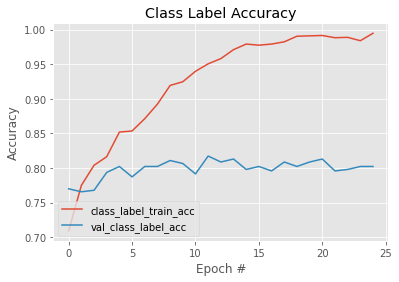

In [ ]:
############			Accuracy 			#############

#The final step is to plot our training and validation accuracy:

# create a new figure for the accuracies
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["class_label_accuracy"],
	label="class_label_train_acc")
plt.plot(N, H.history["val_class_label_accuracy"],
	label="val_class_label_acc")
plt.title("Class Label Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")
# save the accuracies plot
plotPath = os.path.sep.join([config.PLOTS_PATH, "accs.png"])
plt.savefig(plotPath)


In [ ]:
import IPython
display(IPython.display.Audio(url="https://ssl.gstatic.com/dictionary/static/sounds/20180430/complete--_us_1.mp3", autoplay=True))

#Load the Model again from Cloud 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#**for 25 epochs** (batch + layer) normalization

In [ ]:
loss,bbx_loss, class_label_loss, bbx_accu, class_label_accu = model.evaluate(test_images, testTargets, verbose = 1)
print("Accuracy for class label on test set is : {}". format(class_label_accu))
print("Accuracy for bounding_box on test set is :{}".format(bbx_accu))

15/15 [==============================] - 2s 121ms/step - loss: 1.5221 - bounding_box_loss: 0.0049 - class_label_loss: 1.5173 - bounding_box_accuracy: 0.8516 - class_label_accuracy: 0.7957
Accuracy for class label on test set is : 0.7956989407539368
Accuracy for bounding_box on test set is :0.85161292552948


###after removing layer normalization 

In [ ]:
loss,bbx_loss, class_label_loss, bbx_accu, class_label_accu = model.evaluate(test_images, testTargets, verbose = 1)
print("Accuracy for class label on test set is : {}". format(class_label_accu))
print("Accuracy for bounding_box on test set is :{}".format(bbx_accu))

15/15 [==============================] - 2s 126ms/step - loss: 0.9342 - bounding_box_loss: 0.0050 - class_label_loss: 0.9293 - bounding_box_accuracy: 0.8645 - class_label_accuracy: 0.8022
Accuracy for class label on test set is : 0.802150547504425
Accuracy for bounding_box on test set is :0.8645161390304565


###without any normalization

In [ ]:
loss,bbx_loss, class_label_loss, bbx_accu, class_label_accu = model.evaluate(test_images, testTargets, verbose = 1)
print("Accuracy for class label on test set is : {}". format(class_label_accu))
print("Accuracy for bounding_box on test set is :{}".format(bbx_accu))

15/15 [==============================] - 2s 127ms/step - loss: 0.7941 - bounding_box_loss: 0.0050 - class_label_loss: 0.7891 - bounding_box_accuracy: 0.8581 - class_label_accuracy: 0.8022
Accuracy for class label on test set is : 0.802150547504425
Accuracy for bounding_box on test set is :0.8580645322799683


##for 100 epochs

In [ ]:
from tensorflow import keras
model = keras.models.load_model('/content/drive/MyDrive/vgg_16_approach/outputs/after 100 epochs/detector_vgg16.h5')

In [ ]:
model.metrics_names

['loss',
 'bounding_box_loss',
 'class_label_loss',
 'bounding_box_accuracy',
 'class_label_accuracy']

##accuracy for 100 epochs in VGG16

In [ ]:
loss,bbx_loss, class_label_loss, bbx_accu, class_label_accu = model.evaluate(test_images, testTargets, verbose = 1)
print("Accuracy for class label on test set is : {}". format(class_label_accu))
print("Accuracy for bounding_box on test set is :{}".format(bbx_accu))

15/15 [==============================] - 2s 119ms/step - loss: 1.5221 - bounding_box_loss: 0.0049 - class_label_loss: 1.5173 - bounding_box_accuracy: 0.8516 - class_label_accuracy: 0.7957
Accuracy for class label on test set is : 0.7956989407539368
Accuracy for bounding_box on test set is :0.85161292552948



# for 250 epochs accuracy

In [ ]:
from tensorflow import keras
model = keras.models.load_model('/content/drive/MyDrive/vgg_16_approach/outputs/after 250 epochs>> 9.14pm june 14/detector_vgg16.h5')



In [ ]:
loss,bbx_loss, class_label_loss, bbx_accu, class_label_accu = model.evaluate(test_images, testTargets, verbose = 1)
print("Accuracy for class label on test set is : {}". format(class_label_accu))
print("Accuracy for bounding_box on test set is :{}".format(bbx_accu))


15/15 [==============================] - 2s 127ms/step - loss: 2.0096 - bounding_box_loss: 0.0048 - class_label_loss: 2.0049 - bounding_box_accuracy: 0.8215 - class_label_accuracy: 0.8022
Accuracy for class label on test set is : 0.802150547504425
Accuracy for bounding_box on test set is :0.8215053677558899


#Predictions


In [ ]:
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/vgg_16_approach/outputs/after_25_removing_layer_normalization/detector_vgg16.h5')

In [ ]:
lb = pickle.loads(open('/content/drive/MyDrive/vgg_16_approach/outputs/after_25_removing_layer_normalization/lb.pickle','rb').read())

In [ ]:
from google.colab import files
input_image = files.upload()

Saving test_car2.jpg to test_car2.jpg


In [ ]:
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from google.colab.patches import cv2_imshow
import numpy as np
import argparse
import imutils
import pickle
import cv2
import os
import PIL

In [ ]:
# define helper functions
def imShow(path):
    import cv2
    import matplotlib.pyplot as plt
    %matplotlib inline
    
    image = cv2.imread(path)
    height, width = image.shape[:2]
    resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

    fig = plt.gcf()
    fig.set_size_inches(18, 10)
    plt.axis("off")
    plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
    plt.show()

# use this to upload files
def upload():
    from google.colab import files
    uploaded = files.upload() 
    for name, data in uploaded.items():
      with open(name, 'wb') as f:
        f.write(data)
        print ('saved file', name)

# use this to download a file  
def download(path):
    from google.colab import files
    files.download(path)

In [ ]:
upload()

Saving test_car2.jpg to test_car2 (1).jpg
saved file test_car2.jpg


In [ ]:
image = load_img('test_car2.jpg', target_size=(224,224))
image = img_to_array(image) / 255.0
image = np.expand_dims(image,axis=0)

In [ ]:
bbx_pred, labels_pred = model.predict(image)
(sx,sy,ex,ey) = bbx_pred[0]


i= np.argmax(labels_pred, axis=1)
print(lb.classes_)
label = lb.classes_[i][0]
if label == 0:
    label = 'emergency'
else: label = 'non-emergency'

[0 1]


In [ ]:
print(sx,sy,ex,ey)

0.07341185 0.11285567 0.67320055 0.85745937


In [ ]:
image = cv2.imread('test_car2.jpg')
raw_image = cv2.imread('test_car2.jpg')
image = imutils.resize(image, width=600)
(h,w) = image.shape[:2]

sx = int(sx * w)
sy = int(sy * h)
ex = int(ex * w)
ey = int(ey * h)


y = sy - 10 if  sy -10 > 10 else sy +10
cv2.putText(image, str(label), (sx, y), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)
cv2.rectangle(image, (sx,sy), (ex,ey), (0,255,0), 2)
#cv2.rectangle(image, (startX, startY), (endX, endY), (0, 0, 255), 2)


array([[[213, 207, 202],
        [213, 207, 202],
        [213, 207, 202],
        ...,
        [247, 247, 247],
        [248, 248, 248],
        [242, 242, 242]],

       [[211, 205, 200],
        [211, 205, 200],
        [211, 205, 200],
        ...,
        [254, 254, 254],
        [255, 255, 255],
        [250, 250, 250]],

       [[211, 205, 200],
        [211, 205, 200],
        [211, 205, 200],
        ...,
        [254, 254, 254],
        [255, 255, 255],
        [250, 250, 250]],

       ...,

       [[216, 213, 209],
        [216, 213, 209],
        [215, 212, 208],
        ...,
        [217, 210, 207],
        [217, 210, 207],
        [216, 209, 206]],

       [[214, 211, 207],
        [213, 210, 206],
        [210, 207, 203],
        ...,
        [215, 208, 205],
        [215, 208, 205],
        [216, 209, 206]],

       [[212, 209, 205],
        [212, 209, 205],
        [211, 208, 204],
        ...,
        [213, 206, 203],
        [213, 206, 203],
        [215, 208, 205]]

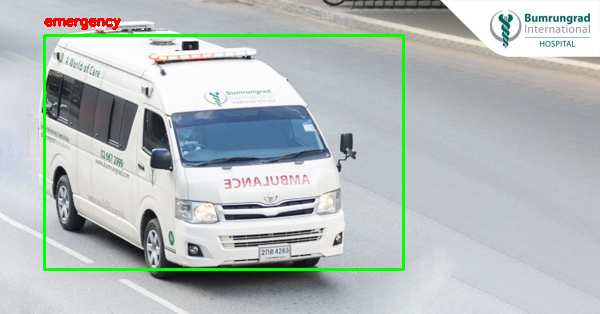

In [ ]:
from google.colab.patches import cv2_imshow
#cv2_imshow(raw_image)
cv2_imshow(image)


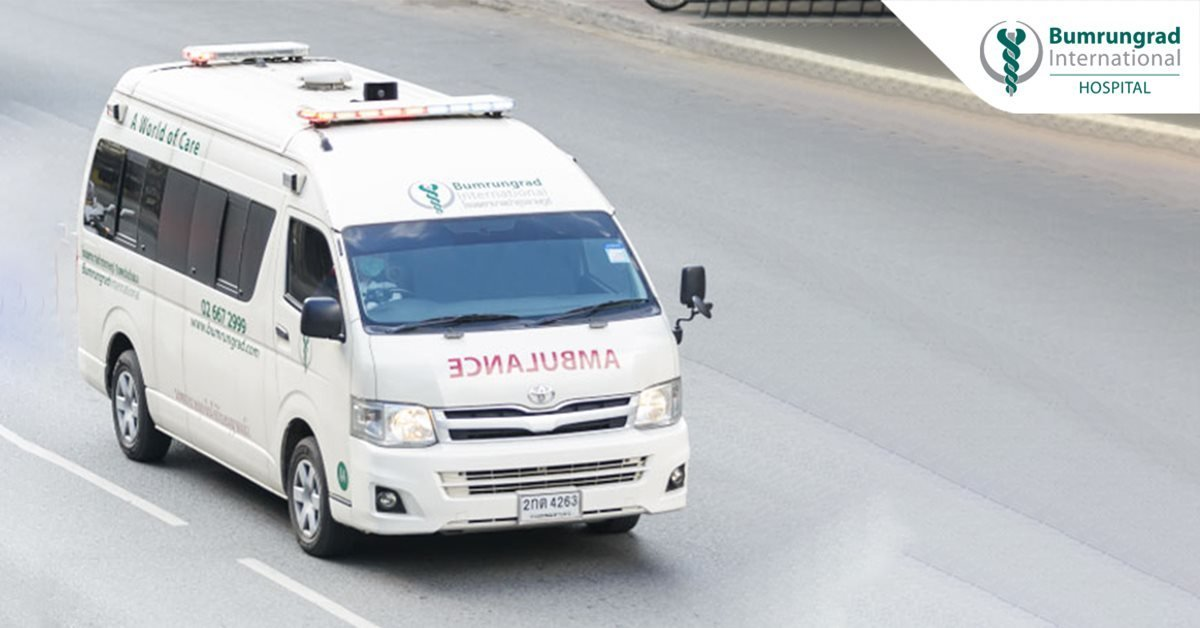

In [ ]:
cv2_imshow(raw_image)

In [ ]:
upload()

Saving test_4.jpg to test_4.jpg
saved file test_4.jpg


[0 1]


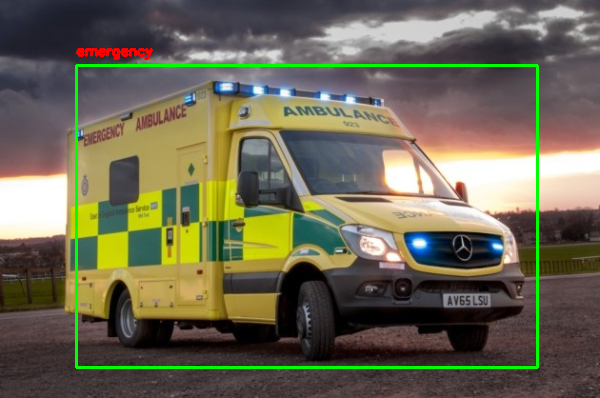

In [ ]:
image = load_img('test_4.jpg', target_size=(224,224))
image = img_to_array(image) / 255.0
image = np.expand_dims(image,axis=0)

bbx_pred, labels_pred = model.predict(image)
(sx,sy,ex,ey) = bbx_pred[0]


i= np.argmax(labels_pred, axis=1)
print(lb.classes_)
label = lb.classes_[i][0]
if label == 1:
    label = 'emergency'
else: label = 'non-emergency'

image = cv2.imread('test_4.jpg')
raw_image = cv2.imread('test_4.jpg')
image = imutils.resize(image, width=600)
(h,w) = image.shape[:2]

sx = int(sx * w)
sy = int(sy * h)
ex = int(ex * w)
ey = int(ey * h)


y = sy - 10 if  sy -10 > 10 else sy +10
cv2.putText(image, str(label), (sx, y), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)
cv2.rectangle(image, (sx,sy), (ex,ey), (0,255,0), 2)
cv2_imshow(image)

In [ ]:
#model.predict_proba(image)